<h1>Prepare Data</h1>

In [20]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

SECONDS_IN_YEAR = (dt.datetime(2021, 1, 1) - dt.datetime(2020, 1, 1)).total_seconds()

def get_population_density(location):
    if location == "Kenosha;WI":
        return 1
    elif location == "Hackensack;NJ":
        return 2
    elif location == "St. Louis;MO":
        return 3
    elif location == "Ellicott City;MD":
        return 4
    elif location == "Baltimore;MD":
        return 5
    elif location == "Catonsville;MD":
        return 6
    elif location == "North Bethesda;MD":
        return 7
    elif location == "Los Angeles;CA":
        return 8

def get_SINE(date):
    seconds = (date - dt.datetime(2020, 1, 1, 0)).total_seconds()
    return np.sin(2 * np.pi * seconds / SECONDS_IN_YEAR)

def get_COSINE(date):
    seconds = (date - dt.datetime(2020, 1, 1, 0)).total_seconds()
    return np.cos(2 * np.pi * seconds / SECONDS_IN_YEAR)

def get_hour_difference(start_datetime, end_datetime):
    return (end_datetime - start_datetime).total_seconds() / 3600

# Import file
#import_file = "DoorDash_Kenosha_WI_V2.csv"
#import_file = "DoorDash_Hackensack_NJ_V2.csv"
#import_file = "DoorDash_St._Louis_MO_V2.csv"
#import_file = "DoorDash_MD_V2.csv"
#import_file = "DoorDash_Los_Angeles_CA_V2.csv"
import_file = "DoorDash_Combined_V2.csv"
#columns = ["Location", "Start_Datetime", "End_Datetime", "DPH", "TEPH"]
columns = ["Start_Datetime", "Deliveries", "Location", "Total_Earnings", "DPH", "ID", "End_Datetime", "TEPH"]
df = pd.read_csv(import_file, names=columns)

# Change to numerical data
df["Location"] = df["Location"].map(get_population_density)
df["Start_Datetime"] = pd.to_datetime(df["Start_Datetime"], format="%Y-%m-%dT%H:%MZ", errors="coerce")
df["DayOfWeek"] = df["Start_Datetime"].dt.dayofweek
df["Start_Datetime"] = (df["Start_Datetime"] - dt.datetime(2020, 1, 1)).dt.total_seconds()
df["Start_Datetime_SINE"] = np.sin(2 * np.pi * df["Start_Datetime"] / SECONDS_IN_YEAR)
df["Start_Datetime_COSINE"] = np.cos(2 * np.pi * df["Start_Datetime"] / SECONDS_IN_YEAR)
df["End_Datetime"] = pd.to_datetime(df["End_Datetime"], format="%Y-%m-%dT%H:%MZ", errors="coerce")
df["End_Datetime"] = (df["End_Datetime"] - dt.datetime(2020, 1, 1)).dt.total_seconds()
df["End_Datetime_SINE"] = np.sin(2 * np.pi * df["End_Datetime"] / SECONDS_IN_YEAR)
df["End_Datetime_COSINE"] = np.cos(2 * np.pi * df["End_Datetime"] / SECONDS_IN_YEAR)
df = df[["Location", "Start_Datetime_SINE", "Start_Datetime_COSINE", "End_Datetime_SINE", "End_Datetime_COSINE", "DayOfWeek", "DPH", "TEPH"]]

# Separate features and classes
feature_names = ["Location", "Start_Datetime_SINE", "Start_Datetime_COSINE", "End_Datetime_SINE", "End_Datetime_COSINE", "DayOfWeek"]
all_features = df[feature_names].values
all_classes_TEPH = df["TEPH"].values

# Normalize data
scaler = preprocessing.StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)

# Test inputs
location = get_population_density("Kenosha;WI")
start_datetime = dt.datetime(2020, 10, 5, 12, 0)
end_datetime = dt.datetime(2020, 10, 5, 13, 0)
start_datetime_SINE = get_SINE(start_datetime)
start_datetime_COSINE = get_COSINE(start_datetime)
end_datetime_SINE = get_SINE(end_datetime)
end_datetime_COSINE = get_COSINE(end_datetime)
dayOfWeek = start_datetime.weekday()
hour_difference = get_hour_difference(start_datetime, end_datetime)

df.describe()

,Location,Start_Datetime_SINE,Start_Datetime_COSINE,End_Datetime_SINE,End_Datetime_COSINE,DayOfWeek,DPH,TEPH
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,1.884106,0.282596,-0.565230,0.282011,-0.566092,2.652318,2.080033,17.442781
std,1.058024,0.649193,0.425675,0.649327,0.424708,1.848492,0.605694,6.178973
min,1.000000,-0.996916,-0.999993,-0.996990,-0.999999,0.000000,0.250000,1.720000
25%,1.000000,-0.253114,-0.967003,-0.252075,-0.967002,1.000000,1.710000,13.622500
50%,1.000000,0.251312,-0.695383,0.248858,-0.693650,3.000000,2.085000,17.245000
75%,3.000000,0.936629,-0.238612,0.937530,-0.243954,4.000000,2.400000,21.232500
max,5.000000,1.000000,0.398202,0.999980,0.395138,6.000000,4.620000,40.790000


In [21]:
TEPH_mean = df["TEPH"].mean()
print("TEPH Mean:", TEPH_mean)

TEPH_std = df["TEPH"].std()
print("TEPH STD:", TEPH_std)

TEPH_variance = TEPH_std * TEPH_std
print("TEPH Variance:", TEPH_variance)

TEPH Mean: 17.44278145695364
TEPH STD: 6.178973095657914
TEPH Variance: 38.17970851686434


<h1>Stats</h1>

<h1>Per One Hour</h1>

In [22]:
from scipy.stats import norm

base = norm(loc=TEPH_mean, scale=TEPH_std)
EV = base.expect(lambda x: abs(x - TEPH_mean), lb=0, ub=TEPH_mean)
print("Expected Value:", EV)

Expected Value: 2.419197238638219


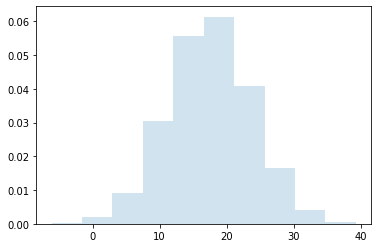

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, sharex=True)
ax.hist(base.rvs(10000), density=True, histtype='stepfilled', alpha=0.2)
plt.show()

<h1>Test Input</h1>

In [24]:
import math

TEPH_test_mean = TEPH_mean * hour_difference
print("TEPH Test Mean:", TEPH_test_mean)
TEPH_test_std = math.sqrt(TEPH_variance * hour_difference)
print("TEPH Test STD:", TEPH_test_std)

base = norm(loc=TEPH_test_mean, scale=TEPH_test_std)
EV = base.expect(lambda x: abs(x - TEPH_test_mean), lb=0, ub=TEPH_test_mean)
print("TEPH Test Expected Value:", EV)

TEPH Test Mean: 17.44278145695364
TEPH Test STD: 6.178973095657914
TEPH Test Expected Value: 2.419197238638219


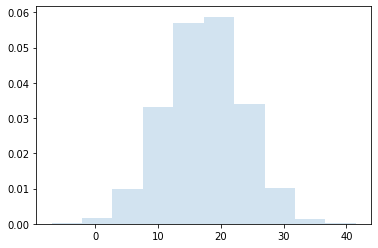

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, sharex=True)
ax.hist(base.rvs(10000), density=True, histtype='stepfilled', alpha=0.2)
plt.show()